In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

## Set Plotting Defaults

In [2]:
import logging
import os

import matplotlib
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Set background and fontsize
rc_params = {
    'pdf.fonttype': 42, # Make fonts editable in Adobe Illustrator
    'ps.fonttype': 42, # Make fonts editable in Adobe Illustrator
    'axes.labelcolor': '#222222',
    'axes.labelsize': 9,
    'text.color': '#222222',
    'font.sans-serif' : 'Helvetica',
    'text.usetex': False,
    'figure.figsize': (7.2, 4.45),
    'xtick.major.size': 0.00,
    'ytick.major.size': 0.00,
    'axes.labelpad': 0.1,
    }
sns.set(style='white', context='paper', rc=rc_params,
        font_scale=1.0)

# Make analysis reproducible
np.random.seed(0)

# Enable logging
logging.basicConfig(level=logging.INFO)

## Simulate Sorted Spikes Data

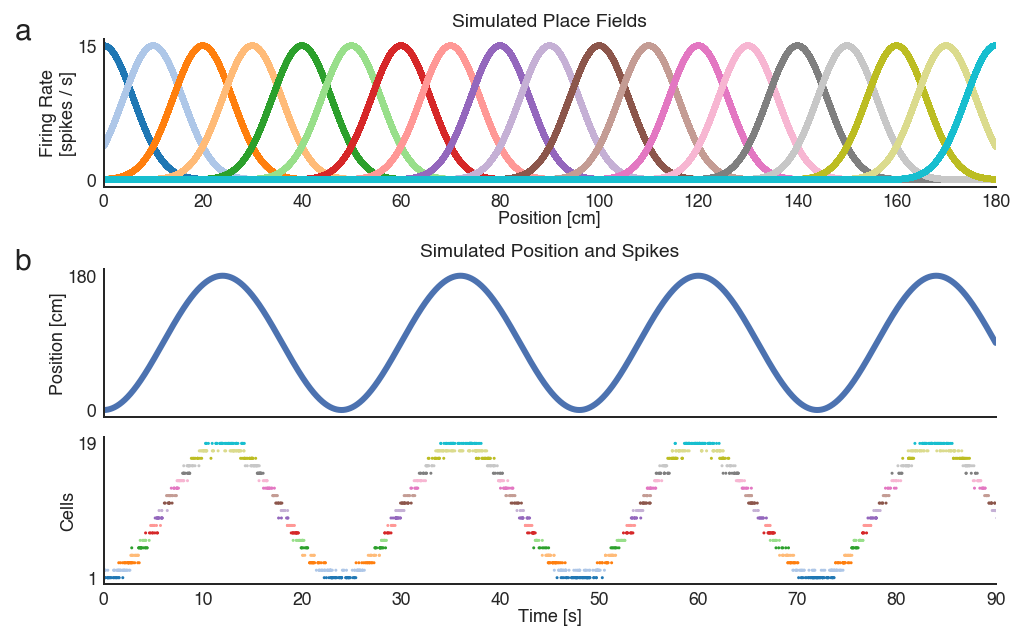

In [3]:
from replay_trajectory_classification.sorted_spikes_simulation import make_simulated_run_data
from replay_trajectory_classification.misc import TWO_COLUMN, GOLDEN_RATIO

time, linear_distance, sampling_frequency, spikes, place_fields = make_simulated_run_data()
spike_ind, neuron_ind = np.nonzero(spikes)
cmap = plt.get_cmap('tab20')

fig, axes = plt.subplots(3, 1, figsize=(TWO_COLUMN, TWO_COLUMN * GOLDEN_RATIO), constrained_layout=True)
for place_field, color in zip(place_fields.T, cmap.colors):
    axes[0].plot(linear_distance, place_field, linewidth=3, color=color)
axes[0].set_xlabel('Position [cm]')
axes[0].set_ylabel('Firing Rate\n[spikes / s]')
axes[0].set_title('Simulated Place Fields')
axes[0].set_xlim((linear_distance.min(), linear_distance.max()))
axes[0].set_yticks([0, np.round(place_fields.max())])
axes[0].text(-0.10, 1.0, 'a', transform=axes[0].transAxes, 
        size=15, weight='extra bold')

axes[1].plot(time, linear_distance, linewidth=3)
axes[1].set_ylabel('Position [cm]')
axes[1].set_title('Simulated Position and Spikes')
axes[1].set_yticks([0, np.round(linear_distance.max())])
axes[1].set_xticks([])
axes[1].set_xlim((0.0, 90.0))
axes[1].text(-0.10, 1.0, 'b', transform=axes[1].transAxes, 
        size=15, weight='extra bold')

c = [cmap.colors[ind] for ind in neuron_ind]
axes[2].scatter(time[spike_ind], neuron_ind + 1, c=c, s=0.5)
axes[2].set_yticks((1, spikes.shape[1]))
axes[2].set_ylabel('Cells')

axes[2].set_xlabel('Time [s]')
axes[2].set_xlim((0.0, 90.0))

sns.despine()

In [4]:
from dask.distributed import Client

Client(n_workers=2,
       threads_per_worker=2,
       processes=True,
       memory_limit='25GB')

Client Scheduler: tcp://127.0.0.1:50532 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 4 Memory: 34.36 GB


## Fit Sorted Spikes Decoder

In [5]:
from replay_trajectory_classification import SortedSpikesDecoder
from replay_trajectory_classification.state_transition import estimate_movement_var

movement_var = estimate_movement_var(linear_distance, sampling_frequency)

classifier = SortedSpikesDecoder(movement_var=movement_var,
                                 replay_speed=1,
                                 spike_model_penalty=0.5,
                                 place_bin_size=np.sqrt(movement_var))
classifier.fit(linear_distance, spikes)

INFO:replay_trajectory_classification.decoder:Fitting initial conditions...
INFO:replay_trajectory_classification.decoder:Fitting state transition...
INFO:replay_trajectory_classification.decoder:Fitting place fields...


SortedSpikesDecoder(infer_track_interior=True,
                    initial_conditions_type='uniform_on_track', knot_spacing=10,
                    movement_var=0.2775841643294236,
                    place_bin_size=0.5268625668325884, position_range=None,
                    replay_speed=1, spike_model_penalty=0.5,
                    transition_type='random_walk')

In [6]:
time_ind = slice(0, 50000)

results = classifier.predict(spikes[time_ind], time=time[time_ind])
results

<xarray.Dataset>
Dimensions:            (position: 342, time: 50000)
Coordinates:
  * time               (time) float64 0.0 0.001 0.002 0.003 ... 50.0 50.0 50.0
  * position           (position) float64 0.2632 0.7895 1.316 ... 179.2 179.7
Data variables:
    likelihood         (time, position) float64 0.9987 0.9989 ... 0.9999 1.0
    causal_posterior   (time, position) float64 0.002928 0.002929 ... 5.475e-78
    acausal_posterior  (time, position) float64 0.04902 0.06562 ... 5.475e-78

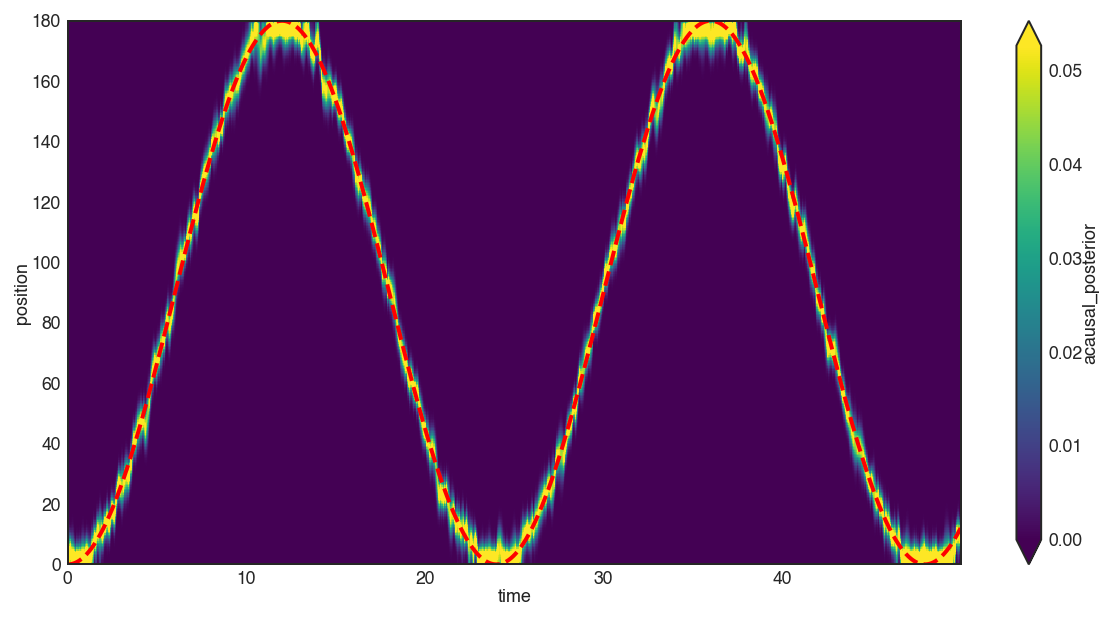

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

results.acausal_posterior.plot(x='time', y='position', ax=ax, robust=True)
ax.plot(time[time_ind], linear_distance[time_ind], linewidth=2, color='red', linestyle='--')

## Fit Sorted Spikes Classifier

In [8]:
from replay_trajectory_classification import SortedSpikesClassifier
from replay_trajectory_classification.state_transition import estimate_movement_var

movement_var = estimate_movement_var(linear_distance, sampling_frequency)

classifier = SortedSpikesClassifier(movement_var=movement_var,
                                    replay_speed=120,
                                    spike_model_penalty=0.5,
                                    place_bin_size=np.sqrt(movement_var))
classifier.fit(linear_distance, spikes)

INFO:replay_trajectory_classification.classifier:Fitting initial conditions...
INFO:replay_trajectory_classification.classifier:Fitting state transition...
INFO:replay_trajectory_classification.classifier:Fitting place fields...


SortedSpikesClassifier(continuous_transition_types=[['random_walk', 'uniform',
                                                     'identity'],
                                                    ['uniform', 'uniform',
                                                     'uniform'],
                                                    ['random_walk', 'uniform',
                                                     'identity']],
                       discrete_transition_diag=0.99,
                       discrete_transition_type='strong_diagonal',
                       infer_track_interior=True,
                       initial_conditions_type='uniform_on_track',
                       knot_spacing=10, movement_var=0.2775841643294236,
                       place_bin_size=0.5268625668325884, position_range=None,
                       replay_speed=120, spike_model_penalty=0.5)

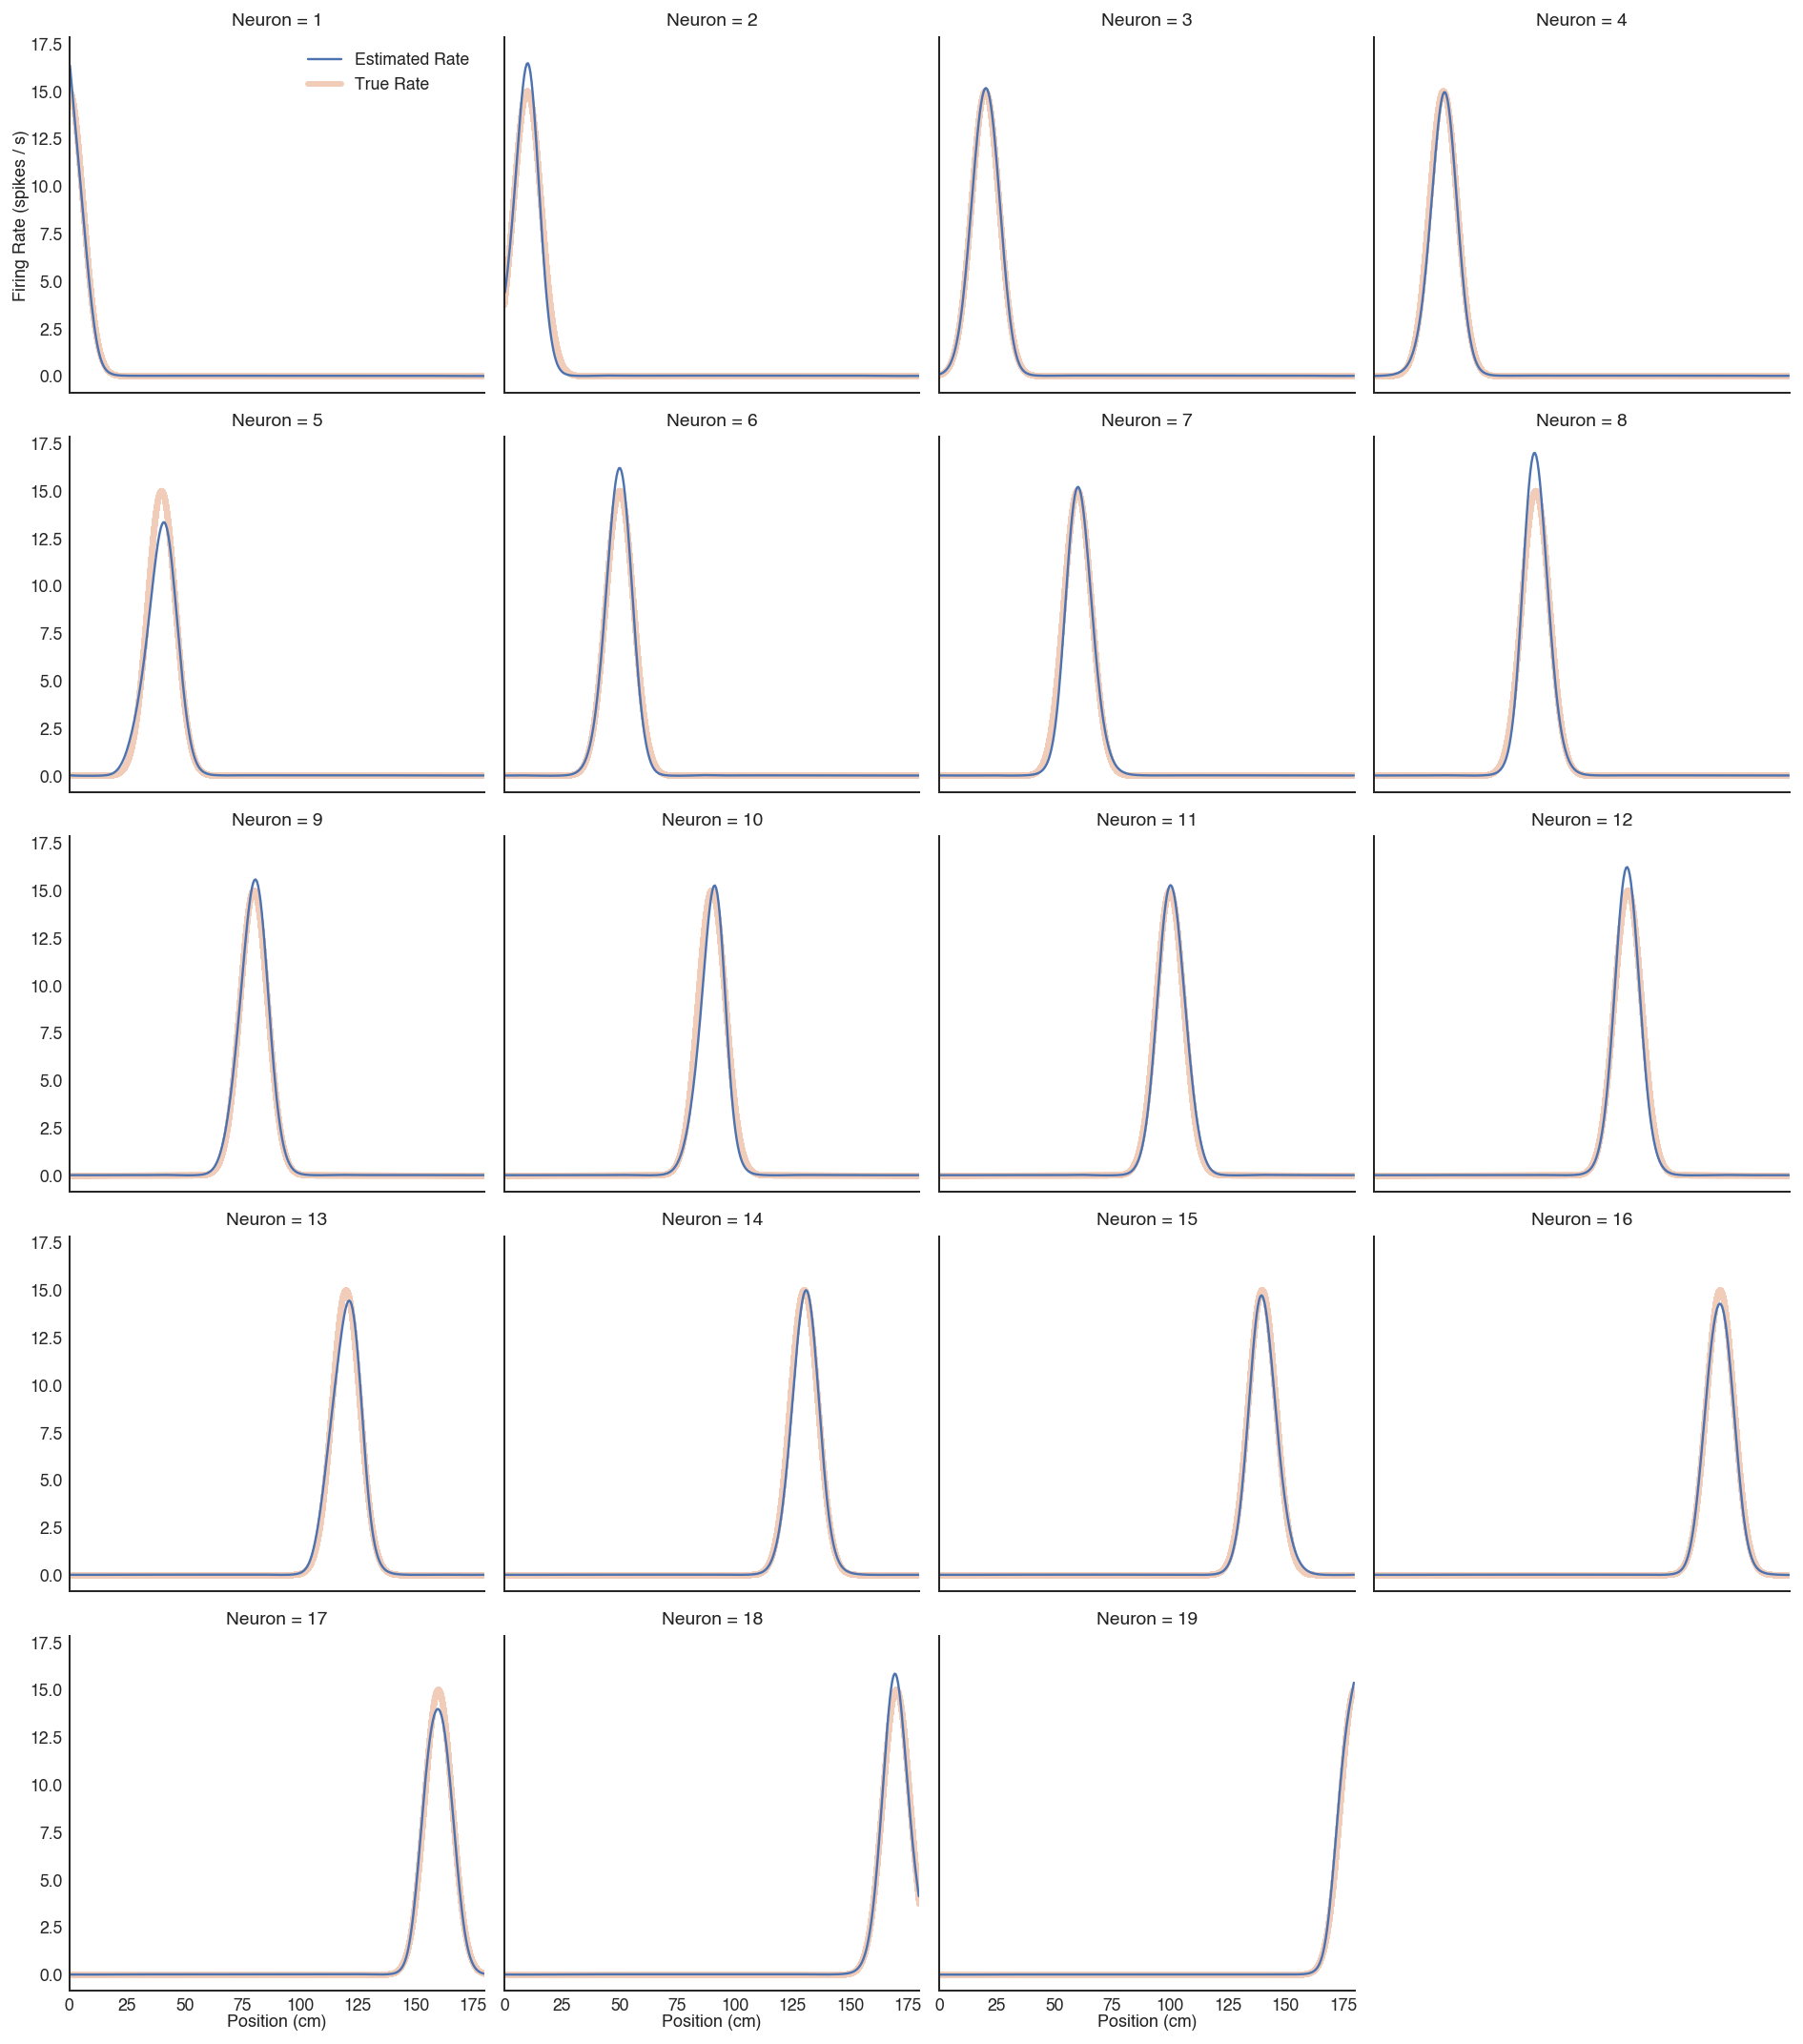

In [9]:
g = (classifier.place_fields_ * sampling_frequency).plot(x='position', col='neuron', col_wrap=4, label='Estimated Rate')
for ind, (ax, true_field) in enumerate(zip(g.axes.flat, place_fields.T)):
    ax.plot(linear_distance, true_field, linestyle='-',
            zorder=0, linewidth=3, alpha=0.4, label='True Rate')
    ax.set_xlim((linear_distance.min(), linear_distance.max()))
    ax.set_title(f'Neuron = {ind + 1}')
sns.despine()

g.axes[0, 0].set_ylabel('Firing Rate (spikes / s)')
g.axes[0, 0].legend(frameon=False)

for ax in g.axes[-1]:
    ax.set_xlabel('Position (cm)')

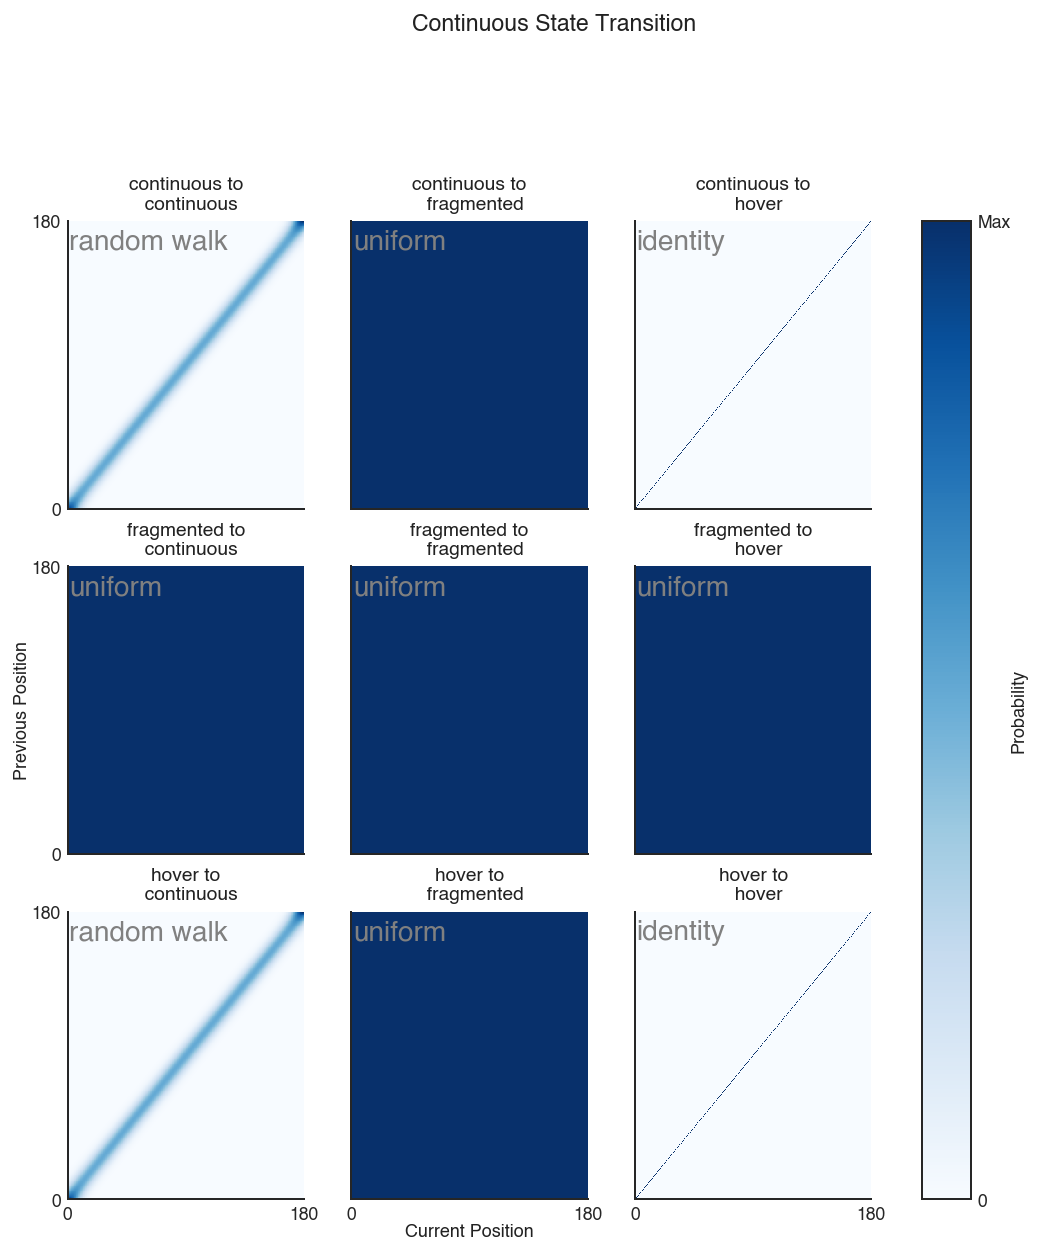

In [10]:
fig, axes = plt.subplots(3, 3, figsize=(9, 9),
                         sharex=True, sharey=True)
continuous_transition_types = np.asarray(classifier.continuous_transition_types)
x, y = np.meshgrid(classifier.place_bin_edges_, classifier.place_bin_edges_)
state_names = ['continuous', 'fragmented', 'hover']
bin_min, bin_max = linear_distance.min(), linear_distance.max()

for j in range(3):
    for k in range(3):
        im = axes[j, k].pcolormesh(x, y, classifier.continuous_state_transition_[j, k], cmap='Blues',
                                   vmin=0.0, vmax=classifier.continuous_state_transition_[j, k].max())
        axes[j, k].text(1, 175, continuous_transition_types[j, k].replace('_', ' '), color='grey',
                        va='top', fontsize=14)
        axes[j, k].set_title(f'{state_names[j]} to\n\t {state_names[k]}')
        axes[j, k].set_xticks((bin_min, bin_max))
        axes[j, k].set_yticks((bin_min, bin_max))
        
plt.xlim((bin_min, bin_max))
plt.ylim((bin_min, bin_max))
axes[1, 0].set_ylabel('Previous Position')
axes[-1, 1].set_xlabel('Current Position')
plt.suptitle('Continuous State Transition', y=1.04)
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), ticks=[0, 1], label='Probability')
cbar.ax.set_yticklabels(['0', 'Max'])
sns.despine()

Text(0.5, 1.0, 'Discrete State Transition')

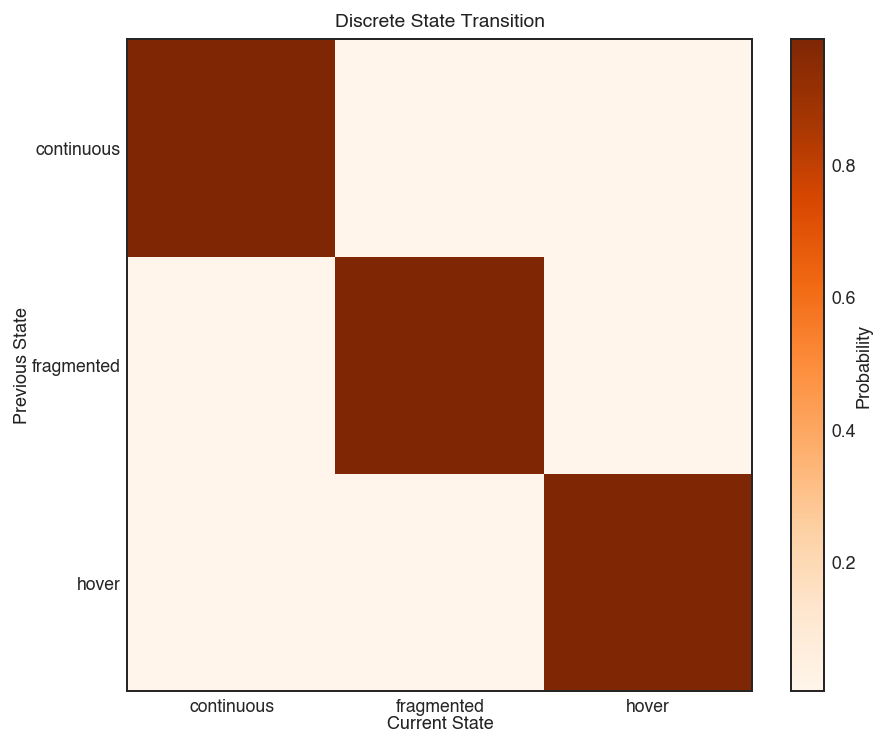

In [11]:
state_names = ['continuous', 'fragmented', 'hover']
edges = np.arange(0.5, 4.5)
x_edges, y_edges = np.meshgrid(edges, edges)
plt.figure(figsize=(7, 6))
plt.pcolormesh(x_edges, y_edges, np.fliplr(classifier.discrete_state_transition_), cmap='Oranges')
plt.xticks(ticks=range(1, 4), labels=state_names)
plt.yticks(ticks=range(1, 4), labels=state_names[::-1])
plt.colorbar(label='Probability')
plt.ylabel('Previous State')
plt.xlabel('Current State')
plt.title('Discrete State Transition')

## Test classifier on different replay types 

In [12]:
from replay_trajectory_classification.misc import TRANSITION_TO_CATEGORY, STATE_COLORS

def plot_classification(replay_time, test_spikes, results):
    fig, axes = plt.subplots(3, 1, figsize=(10, 6), constrained_layout=True, sharex=True)
    spike_time_ind, neuron_ind = np.nonzero(test_spikes)
    axes[0].scatter(replay_time[spike_time_ind], neuron_ind, color='black', zorder=1,
                    marker='|', s=80, linewidth=3)
    axes[0].set_yticks((0, test_spikes.shape[1]))
    axes[0].set_ylabel('Neuron Index')
    replay_probability = results.acausal_posterior.sum('position')
    for state, prob in replay_probability.groupby('state'):
        axes[1].plot(prob.time, prob.values, linewidth=4, label=state, color=STATE_COLORS[state])
    axes[1].set_ylabel('Probability')
    axes[1].set_yticks([0, 1])
    axes[1].set_ylim((-0.01, 1.05))
    axes[1].legend(bbox_to_anchor=(1.15, 0.95), loc='upper right', fancybox=False, shadow=False,
                   ncol=1, frameon=False)
    
    results.acausal_posterior.sum('state').plot(
        x='time', y='position', robust=True, vmin=0.0, ax=axes[2])
    axes[2].set_ylabel('Position [cm]')
    plt.xlim((replay_time.min(), replay_time.max()))
    axes[-1].set_xlabel('Time [ms]')
    sns.despine()

### Continuous

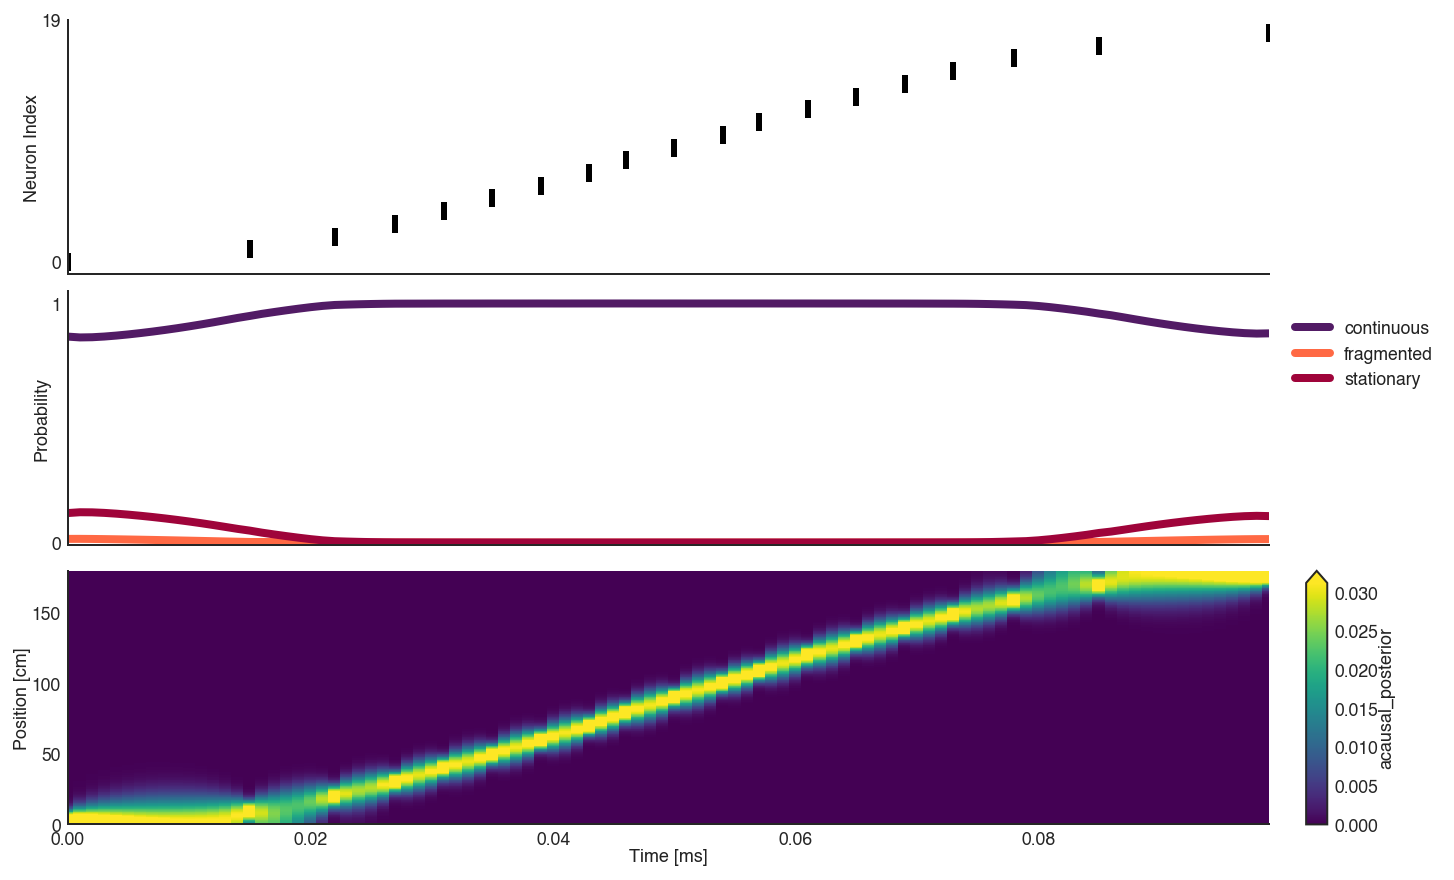

In [13]:
from replay_trajectory_classification.sorted_spikes_simulation import make_continuous_replay

replay_time, test_spikes = make_continuous_replay()
state_names = ['continuous', 'fragmented', 'stationary']
results = classifier.predict(test_spikes, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_spikes, results)

### Hover

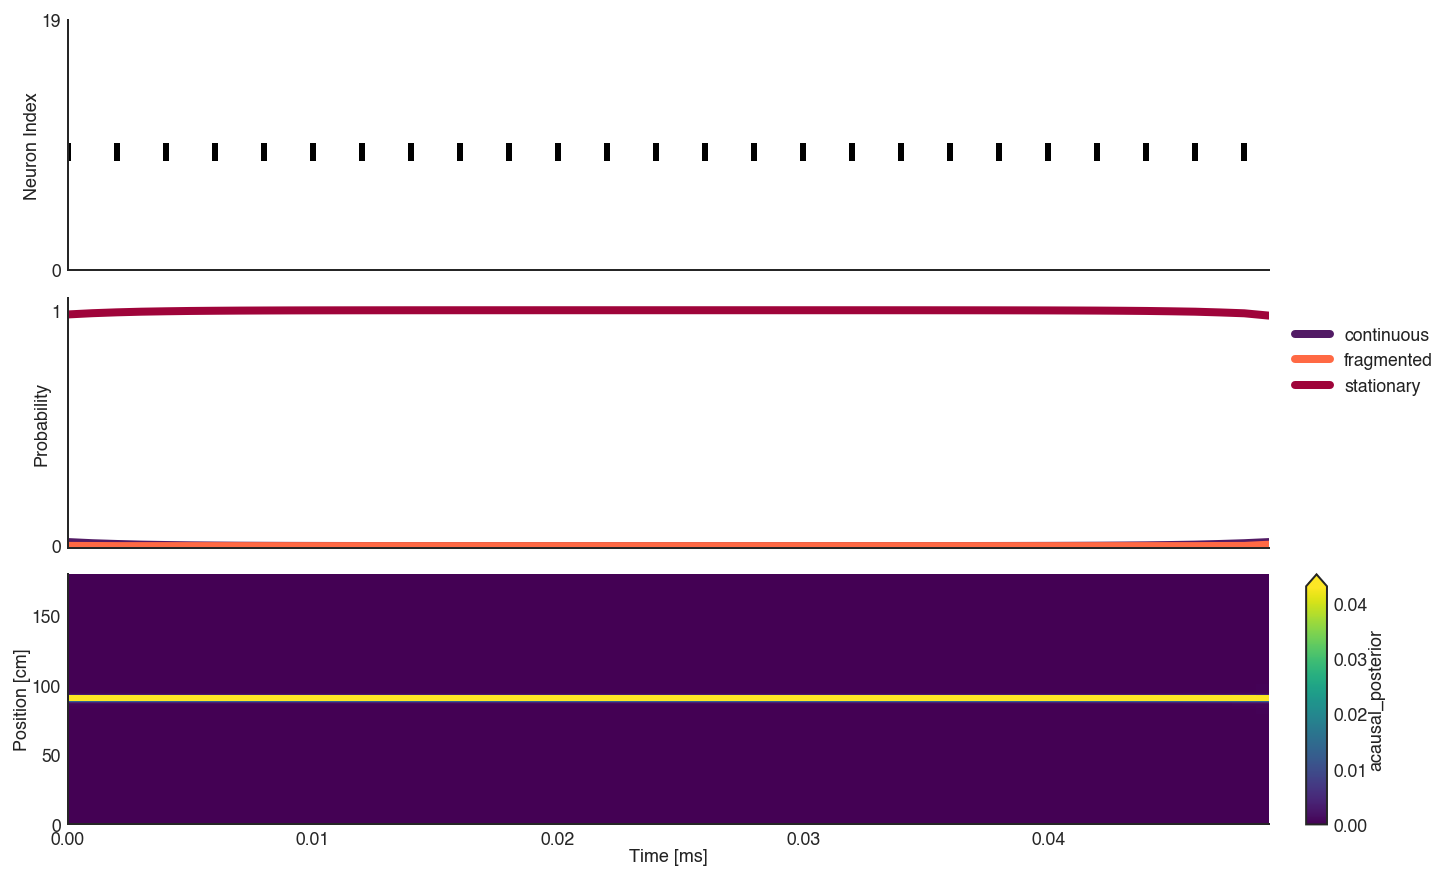

In [14]:
from replay_trajectory_classification.sorted_spikes_simulation import make_hover_replay

replay_time, test_spikes = make_hover_replay()

results = classifier.predict(test_spikes, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_spikes, results)

### Fragmented

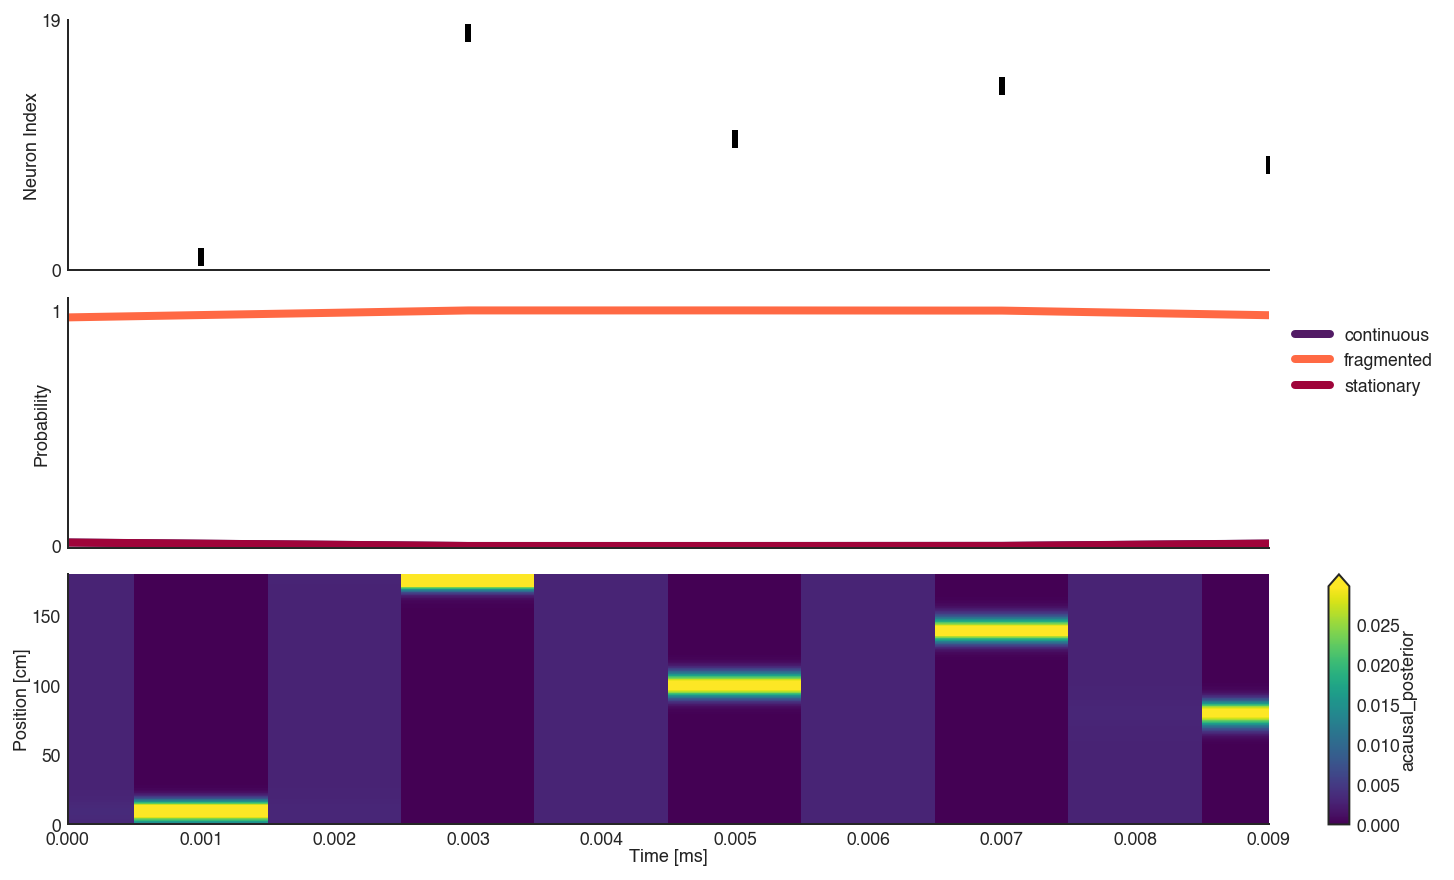

In [15]:
from replay_trajectory_classification.sorted_spikes_simulation import make_fragmented_replay

replay_time, test_spikes = make_fragmented_replay()

results = classifier.predict(test_spikes, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_spikes, results)

### Hover-Continuous-Hover 

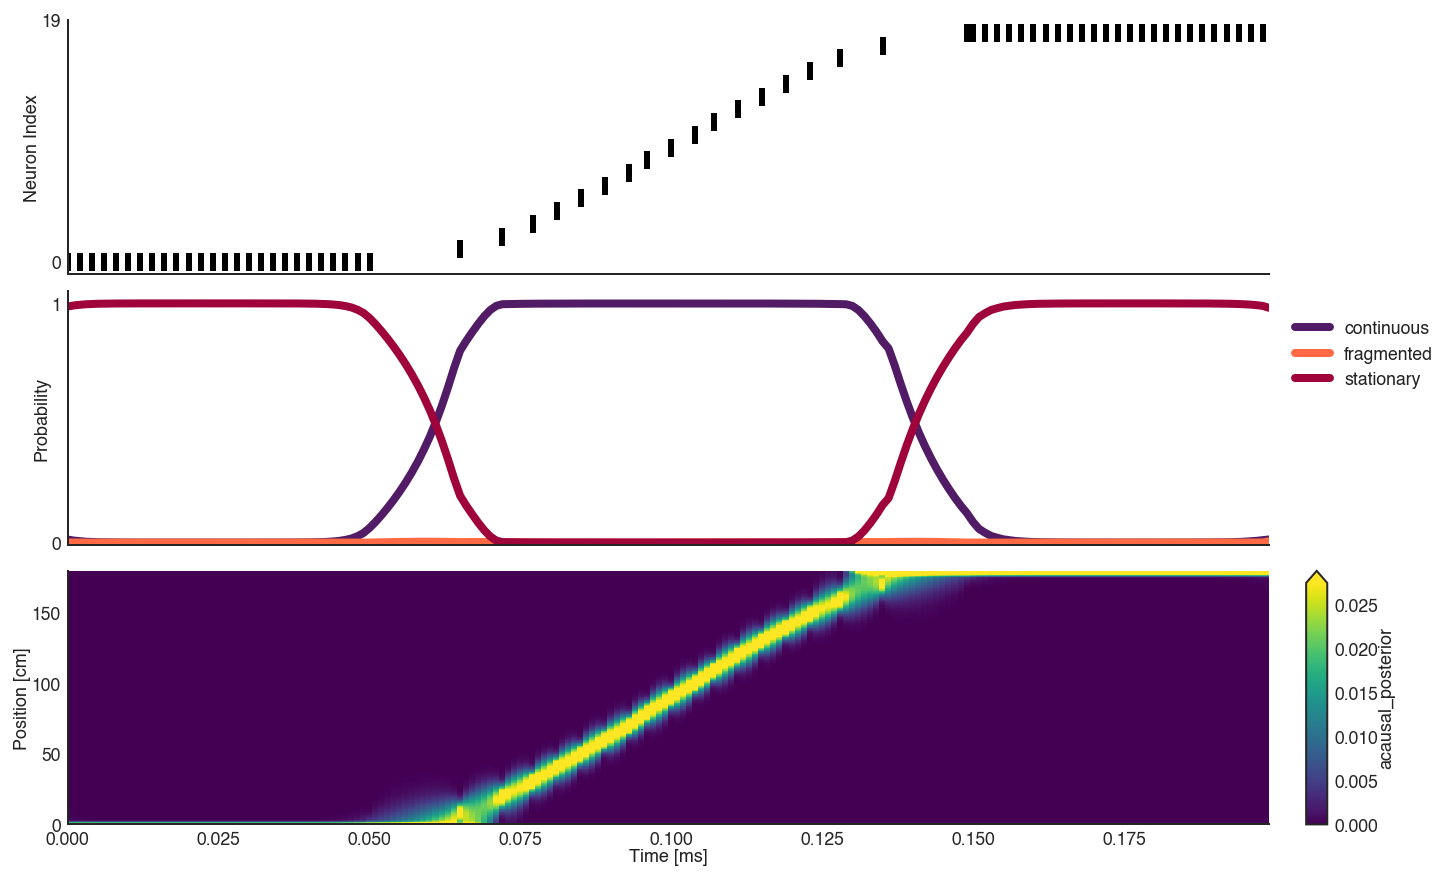

In [16]:
from replay_trajectory_classification.sorted_spikes_simulation import make_hover_continuous_hover_replay

replay_time, test_spikes = make_hover_continuous_hover_replay()

results = classifier.predict(test_spikes, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_spikes, results)

### Fragmented-Hover-Fragmented

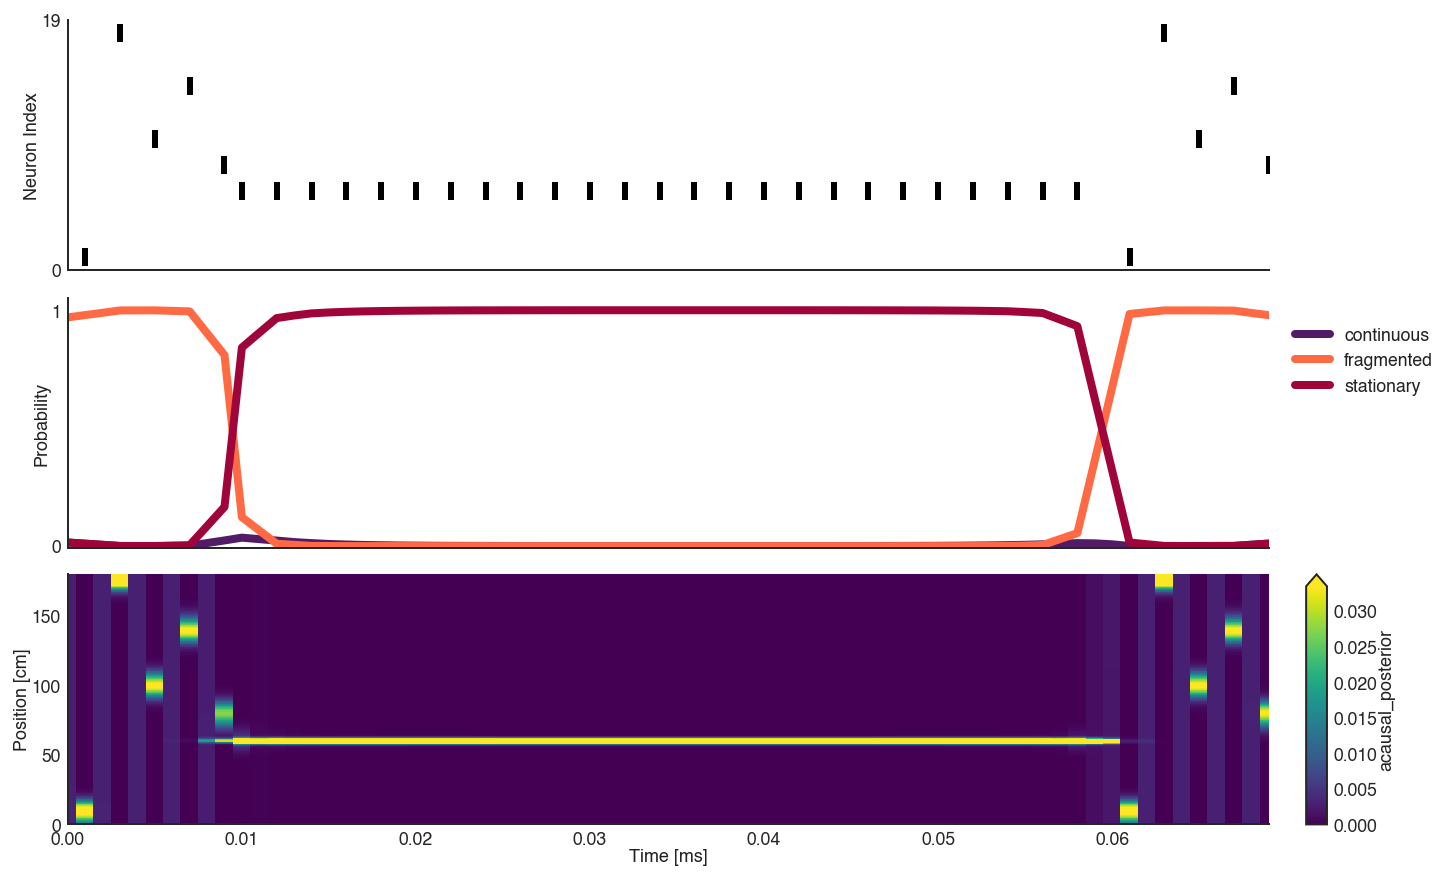

In [17]:
from replay_trajectory_classification.sorted_spikes_simulation import make_fragmented_hover_fragmented_replay

replay_time, test_spikes = make_fragmented_hover_fragmented_replay()

results = classifier.predict(test_spikes, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_spikes, results)

### Fragmented-Continuous-Fragmented

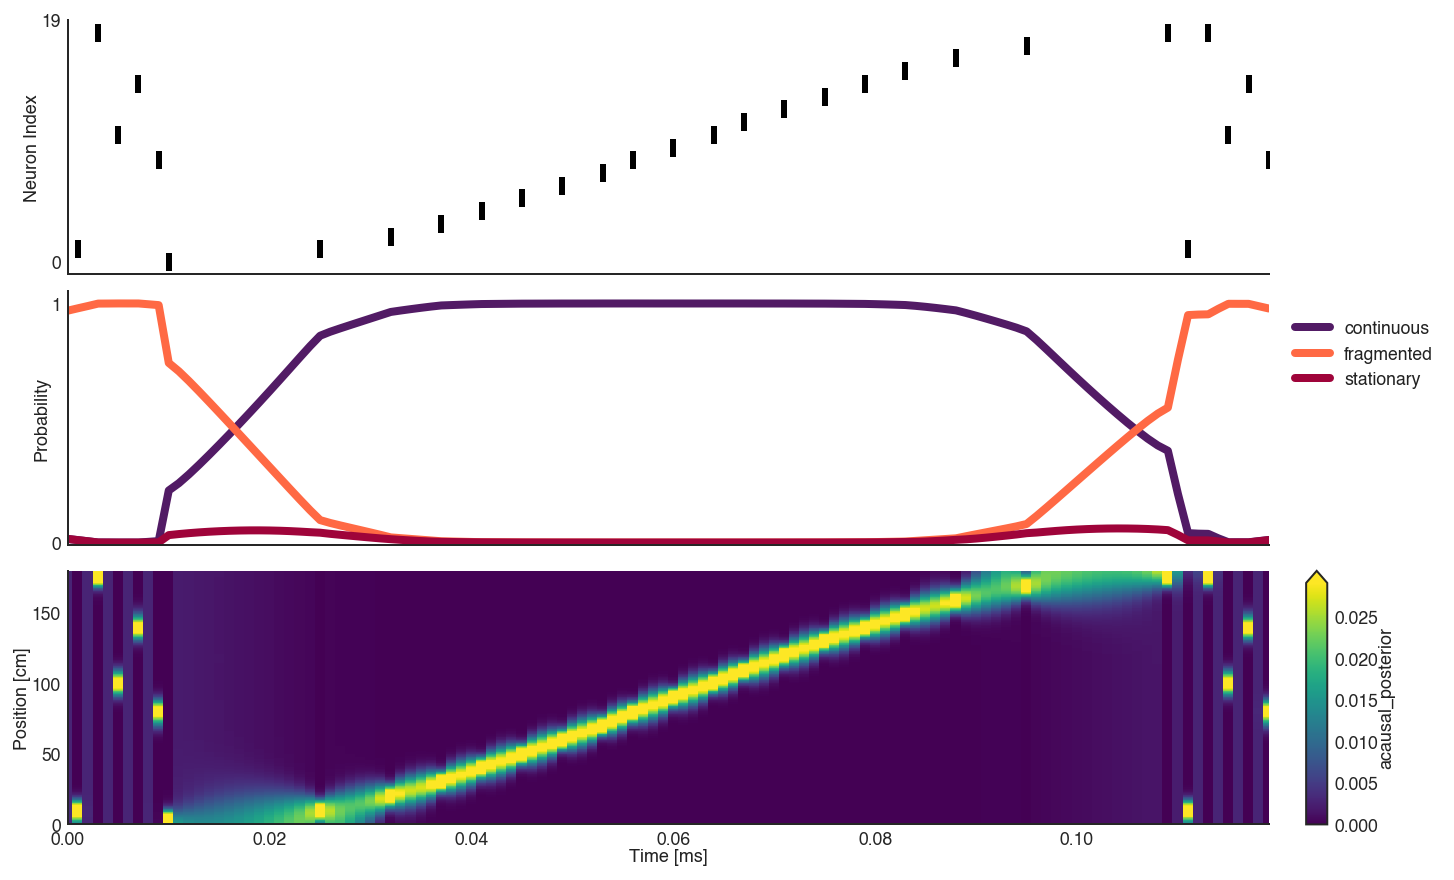

In [18]:
from replay_trajectory_classification.sorted_spikes_simulation import make_fragmented_continuous_fragmented_replay

replay_time, test_spikes = make_fragmented_continuous_fragmented_replay()

results = classifier.predict(test_spikes, time=replay_time, state_names=state_names)
plot_classification(replay_time, test_spikes, results)